In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import models , layers
import matplotlib.pyplot as plt
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten , Input
from tensorflow.keras.models import load_model
from PIL import Image

## Checking GPU

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

it appears that i have both GPU and CPU

In [6]:
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    for device in physical_devices:
        # Print the detailed information about the GPU
        print(tf.test.gpu_device_name(), "\n")
else:
    print("No GPU devices found.")

No GPU devices found.


In [3]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=40

## Reading data

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../Tomato dataset/color",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 18160 files belonging to 10 classes.


In [41]:
class_names = dataset.class_names
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[9 1 4 7 2 5 7 2 4 5 7 0 3 5 6 2 3 4 6 7 7 7 2 5 8 1 3 4 7 0 5 7]


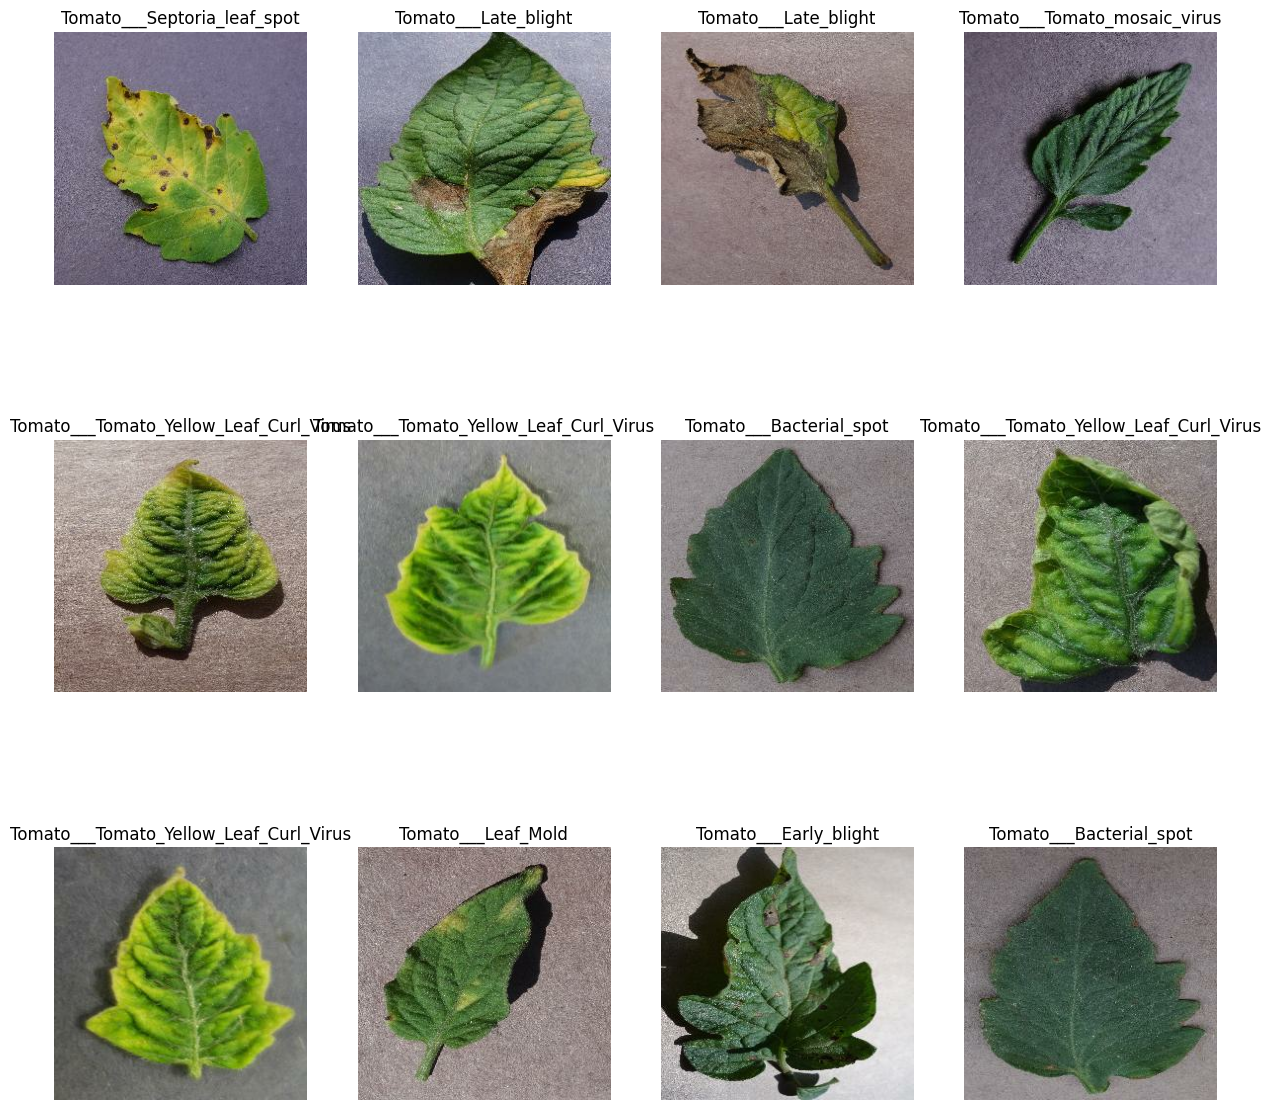

In [7]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
def get_dataset_partitions_tf(ds,train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True, shuffle_size=10000):
    
    ds_size=len(ds)
    
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    
    train_size=int(train_split * ds_size)
    val_size=int(val_split * ds_size)
    
    train_ds=ds.take(train_size)
    
    val_ds= ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [10]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:

data_augmentation = tf.keras.Sequential([layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)])

### Model Building

In [11]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    layers.Rescaling(1/255),
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)          3

In [15]:
history=model.fit(
    train_ds,
    epochs=6,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/6
454/454 [==============================] - 627s 1s/step - loss: 1.3940 - accuracy: 0.5192 - val_loss: 0.8996 - val_accuracy: 0.6864
Epoch 2/6
454/454 [==============================] - 389s 855ms/step - loss: 0.7660 - accuracy: 0.7350 - val_loss: 0.6905 - val_accuracy: 0.7651
Epoch 3/6
454/454 [==============================] - 372s 819ms/step - loss: 0.4972 - accuracy: 0.8243 - val_loss: 0.3545 - val_accuracy: 0.8761
Epoch 4/6
454/454 [==============================] - 413s 909ms/step - loss: 0.3477 - accuracy: 0.8795 - val_loss: 0.3211 - val_accuracy: 0.8968
Epoch 5/6
454/454 [==============================] - 444s 979ms/step - loss: 0.2631 - accuracy: 0.9064 - val_loss: 0.2002 - val_accuracy: 0.9314
Epoch 6/6
454/454 [==============================] - 362s 796ms/step - loss: 0.2203 - accuracy: 0.9202 - val_loss: 0.1705 - val_accuracy: 0.9403


In [16]:
model.evaluate(test_ds)

58/58 [==============================] - 83s 303ms/step - loss: 0.1852 - accuracy: 0.9343


[0.185213103890419, 0.9342672228813171]

In [17]:
model.evaluate(test_ds)

58/58 [==============================] - 10s 176ms/step - loss: 0.1852 - accuracy: 0.9343


[0.1852131336927414, 0.9342672228813171]

In [18]:
model.save("TomatoeFinal.h5")

c:\Users\DELL\anaconda3\envs\tensorfu\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Loading model

In [45]:
# model = load_model("TomatoeFinal.h5")

In [8]:
tf.__version__

'2.5.0'

In [19]:
import numpy as np
for images, labels in test_ds.take(1):
    first_image_true_label = labels[0].numpy()
    print("actual label", class_names[first_image_true_label])
    first_image_predicted_label = np.argmax(model.predict(images)[0])
    print("predicted label", class_names[first_image_predicted_label])

actual label Tomato___Early_blight
1/1 [==============================] - 1s 583ms/step
predicted label Tomato___Early_blight


In [20]:
def predict(model, img):
    im_arr = tf.keras.preprocessing.image.img_to_array(img)
    im_arr = tf.expand_dims(im_arr, 0)

    prediction_for_batch = model.predict(im_arr)

    predicted_label = class_names[np.argmax(prediction_for_batch[0])]
    confidence = round(100* (np.max(prediction_for_batch[0])),2)
    return predicted_label, confidence

1/1 [==============================] - 0s 28ms/step


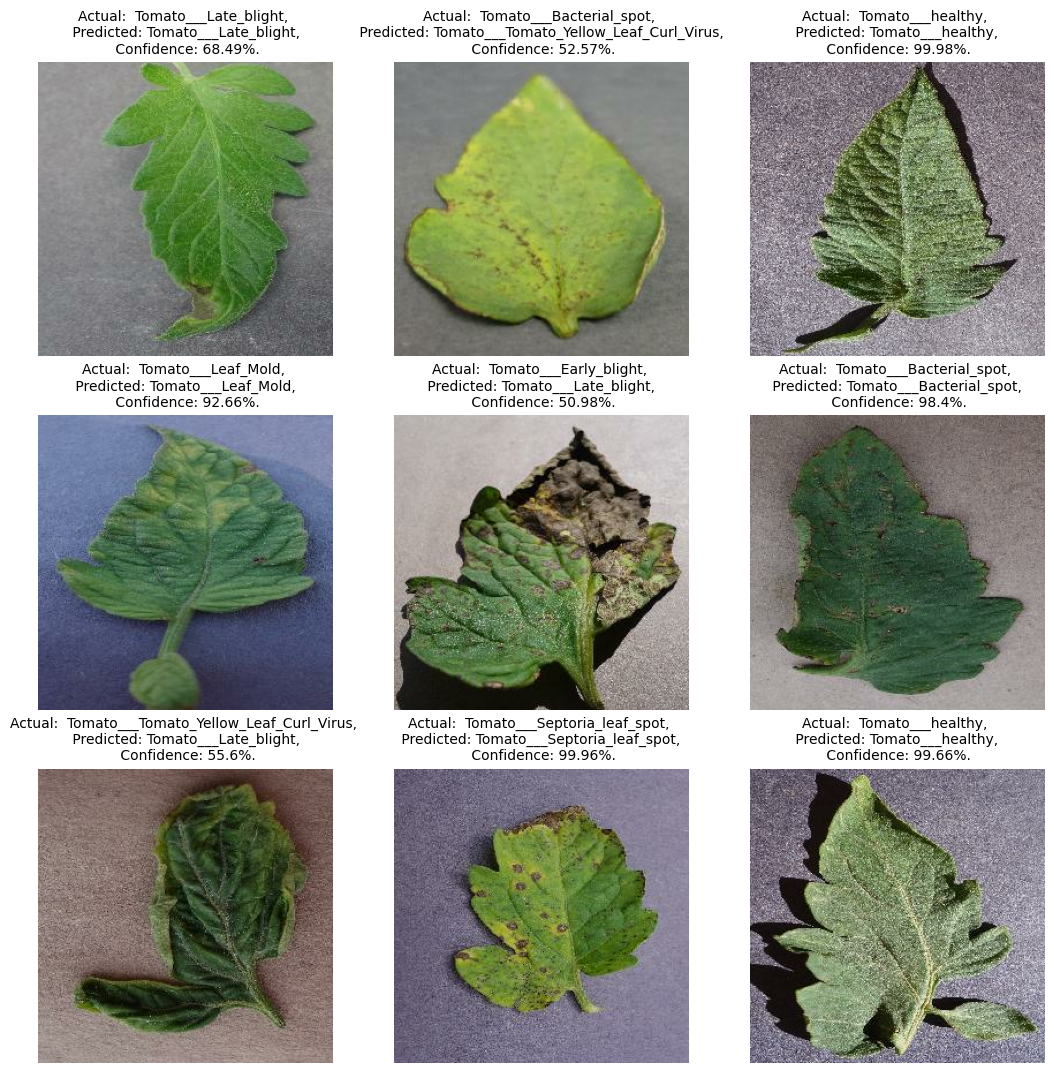

In [26]:
for images, labels in test_ds.take(1):
    plt.figure(figsize=(13, 13))
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_label, confidence = predict(model, images[i].numpy())
        actual_label = class_names[labels[i].numpy()]
        plt.title(f"Actual:  {actual_label}, \n Predicted: {predicted_label}, \n Confidence: {confidence}%.", fontsize=10)
        plt.axis("off")

plt.show()

In [42]:
# from PIL import Image

image = np.array(Image.open("image.png").convert("RGB").resize((256, 256)))

In [43]:
image = np.expand_dims(image,0)

In [44]:
class_names[np.argmax(model.predict(image))]

1/1 [==============================] - 0s 105ms/step


'Tomato___Bacterial_spot'